In [1]:
from os import path
import glob
import os
import cv2
import shutil
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
import torch
import torch.nn as nn

try: 
    import segmentation_models_pytorch as smp
except ModuleNotFoundError:
    ! pip install segmentation_models_pytorch
    
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchmetrics import Dice
from torchmetrics import MetricCollection

import wandb
from pytorch_lightning.loggers import WandbLogger

from pathlib import Path
from typing import Any
from typing import Callable
from typing import Dict
from typing import Tuple, List

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 606.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=6e6c9c25f66639baea2e637acf1f25e7a0bf9145eb316c40985eeabaff2c8ffa
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=83bbc9d9cd347876bea42dfa6eb21479255cc15c49b28d40dfb862bb24078ed5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
wandb_logger = WandbLogger(project="RZD", name="v3_unet", log_model="all")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [27]:
BATCH_SIZE = 12
NUM_WORKERS = 8
LOSS = "lovasz"
OPTIMIZER = "Adam"
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-6
SCHEDULER = None
MIN_LR = 1e-6

FAST_DEV_RUN = False # Debug training
GPUS = 1
MAX_EPOCHS = 3

CLASSES = {0:'background', 7: 'railway', 6: 'other railways', 10: 'trains'}
MAP_MASKS = {7: 1, 6: 2, 10: 3, 0: 0}
MAP_SUBMIT = {1: 7, 2: 6, 3: 10, 0: 0}

TRAIN_DATASET_PATH = '../input/train-dataset/train_dataset_train/train'
TRAIN_PATH = {'images': path.join(TRAIN_DATASET_PATH, 'images'), 'mask': path.join(TRAIN_DATASET_PATH, 'mask')}
ALL_MASKS = glob.glob(path.join(TRAIN_PATH['mask'], '*.png'))
ALL_IMAGES = glob.glob(path.join(TRAIN_PATH['images'], '*.png'))

PATH_TEST = '../input/train-dataset/test_dataset_test'
TEST_IMAGES = glob.glob(path.join(PATH_TEST, '*.png'))


LOSS_FNS = {
    "bce": smp.losses.SoftBCEWithLogitsLoss(),
    "dice": smp.losses.DiceLoss(mode="multiclass"),
    "focal": smp.losses.FocalLoss(mode="multiclass"),
    "jaccard": smp.losses.JaccardLoss(mode="multiclass"),
    "lovasz": smp.losses.LovaszLoss(mode="multiclass"),
    "tversky": smp.losses.TverskyLoss(mode="multiclass"),}

In [16]:
MODEL = smp.Unet(
            encoder_name='efficientnet-b5', 
            encoder_depth=5, 
            encoder_weights='imagenet',
            decoder_channels=(256, 128, 64, 32, 16),
            in_channels=3, 
            classes=4, 
            activation=None
        )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

In [5]:
class RZDDataset(Dataset):
    def __init__(self, image_paths: List[Path] = ALL_IMAGES, mask_paths: List[Path] = ALL_MASKS, transforms: Callable = None):        
        self.image_paths = image_paths

        self.mask_paths = mask_paths

        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask = self._load_mask(mask_path)
        if self.transforms is not None:
            data = self.transforms(image=image, mask=mask)
            image, mask = data["image"], data["mask"]

        return image, mask

    @staticmethod
    def _load_image(image_path: Path) -> np.ndarray:
        return cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)

    @staticmethod
    def _load_mask(mask_path: Path) -> np.ndarray:
        transorm_mask = np.vectorize(lambda x: MAP_MASKS[x])
        return transorm_mask(cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE))

In [6]:
ds = RZDDataset()

In [7]:
def show_examples(name: str, pair: np.array):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(pair[1])
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(pair[0])
    plt.title(f"Mask: {name}")

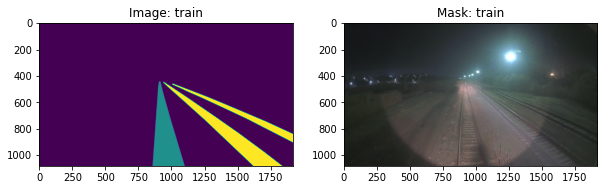

In [8]:
show_examples('train', ds[34])

In [9]:
class RZDDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset=RZDDataset,
        all_images: List[Path] = ALL_IMAGES,
        all_masks: List[Path] = ALL_MASKS,
        train_size_coef: int = 0.9,
        batch_size: int = 8,
        num_workers: int = 2,
        input_shape: Tuple[int, int] = (512, 512),
    ):
        super().__init__()

        self.dataset = dataset
        self.all_images = all_images
        self.all_masks = all_masks
        self.save_hyperparameters()

        self.train_transforms, self.val_transforms = self._init_transforms()

    def _init_transforms(self) -> Tuple[Callable, Callable]:
        train_transforms = [
            A.Resize(*self.hparams.input_shape),
            A.OneOf(
                [
                    A.RandomFog(),
                    A.RandomSunFlare(src_radius=100),
                    A.NoOp(),
                    A.RandomShadow(),
                ]
            ),
            A.HorizontalFlip(p=0.5),
            A.OpticalDistortion(),
            A.RandomBrightnessContrast(),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]

        val_transforms = [
            A.Resize(*self.hparams.input_shape),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]

        return A.Compose(train_transforms), A.Compose(val_transforms)

    def setup(self, stage=None):
        images_train, images_val, masks_train, masks_val = train_test_split(
            self.all_images, self.all_masks, train_size=self.hparams.train_size_coef
        )
        self.train_dataset = self.dataset(
            images_train, masks_train, self.train_transforms
        )
        self.val_dataset = self.dataset(images_val, masks_val, self.val_transforms)

    def train_dataloader(self):
        return self._dataloader(self.train_dataset)

    def val_dataloader(self):
        return self._dataloader(self.val_dataset)

    def _dataloader(self, dataset: RZDDataset) -> DataLoader:
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
        )

In [10]:
def show_batch():
    nrows = 3
    ncols = 3
    batch_size = nrows * ncols
    data_module = RZDDataModule(batch_size=batch_size)
    data_module.setup()
    data_loader = data_module.train_dataloader()

    images, masks = next(iter(data_loader))

    fig, _ = plt.subplots(figsize=(10, 10))
    for i, (image, mask) in enumerate(zip(images, masks)):
        plt.subplot(nrows, ncols, i + 1)
        plt.tight_layout()
        plt.axis('off')

        image = image.permute(1, 2, 0).numpy()
        mask = mask.numpy()

        print(image.shape, image.min(), image.max(), image.mean(), image.std())
        print(mask.shape, mask.min(), mask.max(), mask.mean(), mask.std())

        plt.imshow(image)
        plt.imshow(mask, alpha=0.2)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:96: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:115: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:89: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:108: LightningDeprecationWarning: DataModu

(512, 512, 3) -1.8952821 2.2391286 -0.4318184 0.5138618
(512, 512) 0 3 0.16835403442382812 0.5509510189612071
(512, 512, 3) -2.117904 2.6399999 0.1694407 0.8454323
(512, 512) 0 2 0.111663818359375 0.417061372284027
(512, 512, 3) -1.8431371 2.012549 0.5050333 0.64854425
(512, 512) 0 3 0.2615623474121094 0.6535252403194741
(512, 512, 3) -2.117904 2.6399999 0.31589365 0.70301074
(512, 512) 0 3 0.33214569091796875 0.8535448424717321
(512, 512, 3) -2.117904 2.378562 -0.078245156 0.6725987
(512, 512) 0 1 0.04395294189453125 0.20499044073650657
(512, 512, 3) -1.3301653 2.6399999 -0.049356814 0.53101265
(512, 512) 0 3 0.5809097290039062 0.9816039879656228
(512, 512, 3) -2.0836544 2.6399999 -0.68359476 0.6927809
(512, 512) 0 2 0.07322311401367188 0.31193480582311817
(512, 512, 3) -2.0665298 2.6051416 -0.19026792 0.5780353
(512, 512) 0 2 0.18710708618164062 0.5727006949582777
(512, 512, 3) -2.117904 2.4308496 -0.56604517 0.5185216
(512, 512) 0 2 0.17387771606445312 0.5243748887838441


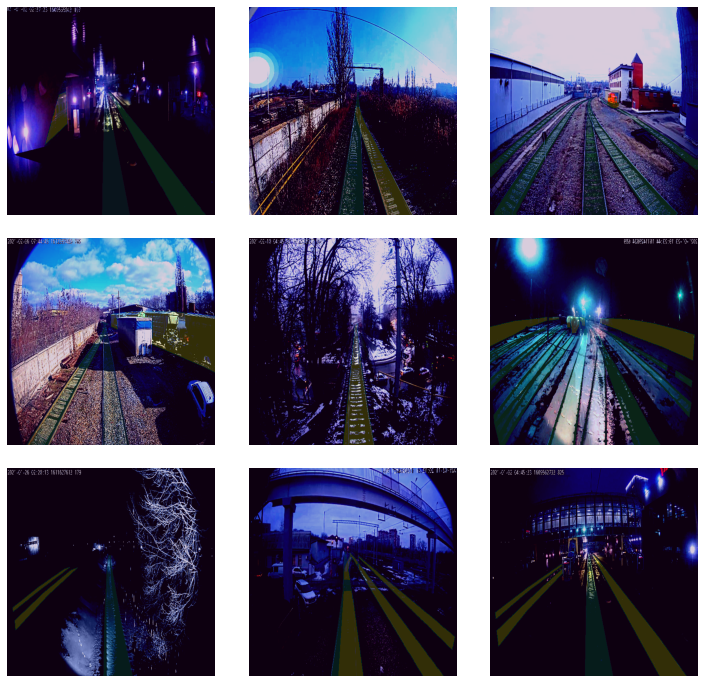

In [11]:
show_batch()

In [12]:
def test_model_and_loss():
    model = MODEL
    data_module = RZDDataModule(batch_size=4)
    data_module.setup()
    data_loader = data_module.train_dataloader()
    images, masks = next(iter(data_loader))
    y_hat = model(images)
    bce_loss = LOSS_FNS['bce']
    dice_loss = LOSS_FNS['dice']
    print(dice_loss(y_hat, masks.type(torch.int64)))

In [13]:
test_model_and_loss()

tensor(0.8345, grad_fn=<MeanBackward0>)


In [28]:
class RZDModel(pl.LightningModule):
    def __init__(
        self,
        loss: str,
        optimizer: str,
        learning_rate: float,
        weight_decay: float,
        scheduler: str,
        T_max: int,
        T_0: int,
        min_lr: int,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = self._init_model()

        self.loss_fn = self._init_loss_fn()

    def _init_model(self) -> nn.Module:
        return MODEL

    def _init_loss_fn(self) -> Callable:
        loss = self.hparams.loss
        assert loss in LOSS_FNS, 'Choose from exstisting!'
        return LOSS_FNS[loss]

    def configure_optimizers(self) -> Dict[str, Any]:
        optimizer_kwargs = dict(
            params=self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay
        )
        if self.hparams.optimizer == "Adam":
            optimizer = torch.optim.Adam(**optimizer_kwargs)
        elif self.hparams.optimizer == "AdamW":
            optimizer = torch.optim.AdamW(**optimizer_kwargs)
        elif self.hparams.optimizer == "SGD":
            optimizer = torch.optim.SGD(**optimizer_kwargs)
        else:
            raise ValueError(f"Unknown optimizer: {self.hparams.optimizer}")

        if self.hparams.scheduler is not None:
            if self.hparams.scheduler == "CosineAnnealingLR":
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                    optimizer, T_max=self.hparams.T_max, eta_min=self.hparams.min_lr
                )
            elif self.hparams.scheduler == "CosineAnnealingWarmRestarts":
                scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                    optimizer, T_0=self.hparams.T_0, eta_min=self.hparams.min_lr
                )
            else:
                raise ValueError(f"Unknown scheduler: {self.hparams.scheduler}")

            return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}
        else:
            return {"optimizer": optimizer}

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        return self.model(images)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self.shared_step(batch, "train")

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        self.shared_step(batch, "val")

    def shared_step(self, batch: Tuple[torch.Tensor, torch.Tensor], stage: str) -> torch.Tensor:
        images, masks = batch
        y_pred = self(images)
        
        loss = self.loss_fn(y_pred, masks.type(torch.int64))

        self._log(loss, metrics={}, stage=stage)

        return loss

    def _log(self, loss: torch.Tensor, metrics: dict, stage: str):
        on_step = True if stage == "train" else False
        self.log(f"{stage}_loss", loss)

    @classmethod
    def load_eval_checkpoint(cls, checkpoint_path: Path, device: str) -> nn.Module:
        module = cls.load_from_checkpoint(checkpoint_path=checkpoint_path).to(device)
        module.eval()

        return module

In [29]:
module = RZDModel.load_eval_checkpoint('../input/weightsunet/epoch5-step3282.ckpt', device='cuda:0')

In [30]:
MODEL = module.model

In [31]:
def train():
    pl.seed_everything(hash("kek") % 2**32 - 1)
    
    model = RZDModel(LOSS, OPTIMIZER, LEARNING_RATE, WEIGHT_DECAY, SCHEDULER, 0, 0, MIN_LR)
    print(model.hparams.learning_rate)
    data_module = RZDDataModule(batch_size=BATCH_SIZE)
    trainer = pl.Trainer(
        logger=wandb_logger,
        max_epochs=MAX_EPOCHS,
        fast_dev_run=FAST_DEV_RUN,
        gpus=torch.cuda.device_count(),
        log_every_n_steps=10,
        precision=16
        )
    trainer.fit(model, data_module)
    return trainer

In [33]:
trainer = train()

0.0001


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /kaggle/working/RZD/11trs34y/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

In [35]:
checkpoint_name = os.listdir('./RZD/11trs34y/checkpoints')[0]

In [37]:
class TestRZD(RZDDataset):
    def __init__(self, image_paths: List[Path] = TEST_IMAGES):
        super().__init__(image_paths)
        
    def __getitem__(self, idx: int) -> torch.Tensor:
        image_path = self.image_paths[idx]
        image_name = image_path.split('/')[-1]
        image = self._load_image(image_path)
        return image, image_name

In [38]:
os.replace(f'./RZD/11trs34y/checkpoints/{checkpoint_name}', f'./{checkpoint_name}')

In [39]:
SUBMISSION_PATH='./submit3'
model = RZDModel.load_eval_checkpoint(f'./{checkpoint_name}', device='cpu')
test_dataset = TestRZD(TEST_IMAGES)

In [40]:
def predict(model: torch.nn.Module, dataset: Dataset, savedir: Path = SUBMISSION_PATH) -> None:
    os.makedirs(SUBMISSION_PATH, exist_ok=True)
    test_transform = {
        "out": lambda shape: A.Resize(*shape),
        "in": A.Compose(
            [A.Resize(*(512, 512)),
             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
             ToTensorV2()]
        ),
    }
    transform_submit = np.vectorize(lambda x: MAP_SUBMIT[x])

    for pair in tqdm(dataset):
        image, image_name = pair
        image_tr = test_transform["in"](image=image)["image"]
        mask = model(image_tr.reshape(1, *image_tr.shape))

        mask_np = (
            mask.argmax(dim=1).numpy().reshape(512, 512)
        )  # size depends on your model
        mask_qhd = test_transform["out"](image.shape[:2])(image=mask_np.astype(np.float64))[
            "image"
        ].astype(int)
        cv2.imwrite(
            os.path.join(SUBMISSION_PATH, image_name), transform_submit(mask_qhd)
        )

In [41]:
predict(model, test_dataset)


100%|██████████| 1000/1000 [50:05<00:00,  3.01s/it]


In [42]:
1

1

In [43]:
path_to_archive = shutil.make_archive(SUBMISSION_PATH,'zip',SUBMISSION_PATH)

In [44]:
TEST_MASKS = glob.glob(os.path.join(SUBMISSION_PATH, '*.png'))

In [45]:
dataset_check = RZDDataset(sorted(TEST_IMAGES), sorted(TEST_MASKS))

In [46]:
def show_batch_t():
    nrows = 3
    ncols = 3
    batch_size = nrows * ncols

    fig, _ = plt.subplots(figsize=(20, 20))
    for i in range(9):
        image, mask = dataset_check[np.random.randint(0, 1000)]
        plt.subplot(nrows, ncols, i + 1)
        plt.tight_layout()
        plt.axis('off')

        plt.imshow(image)
        plt.imshow(mask, alpha=0.2)

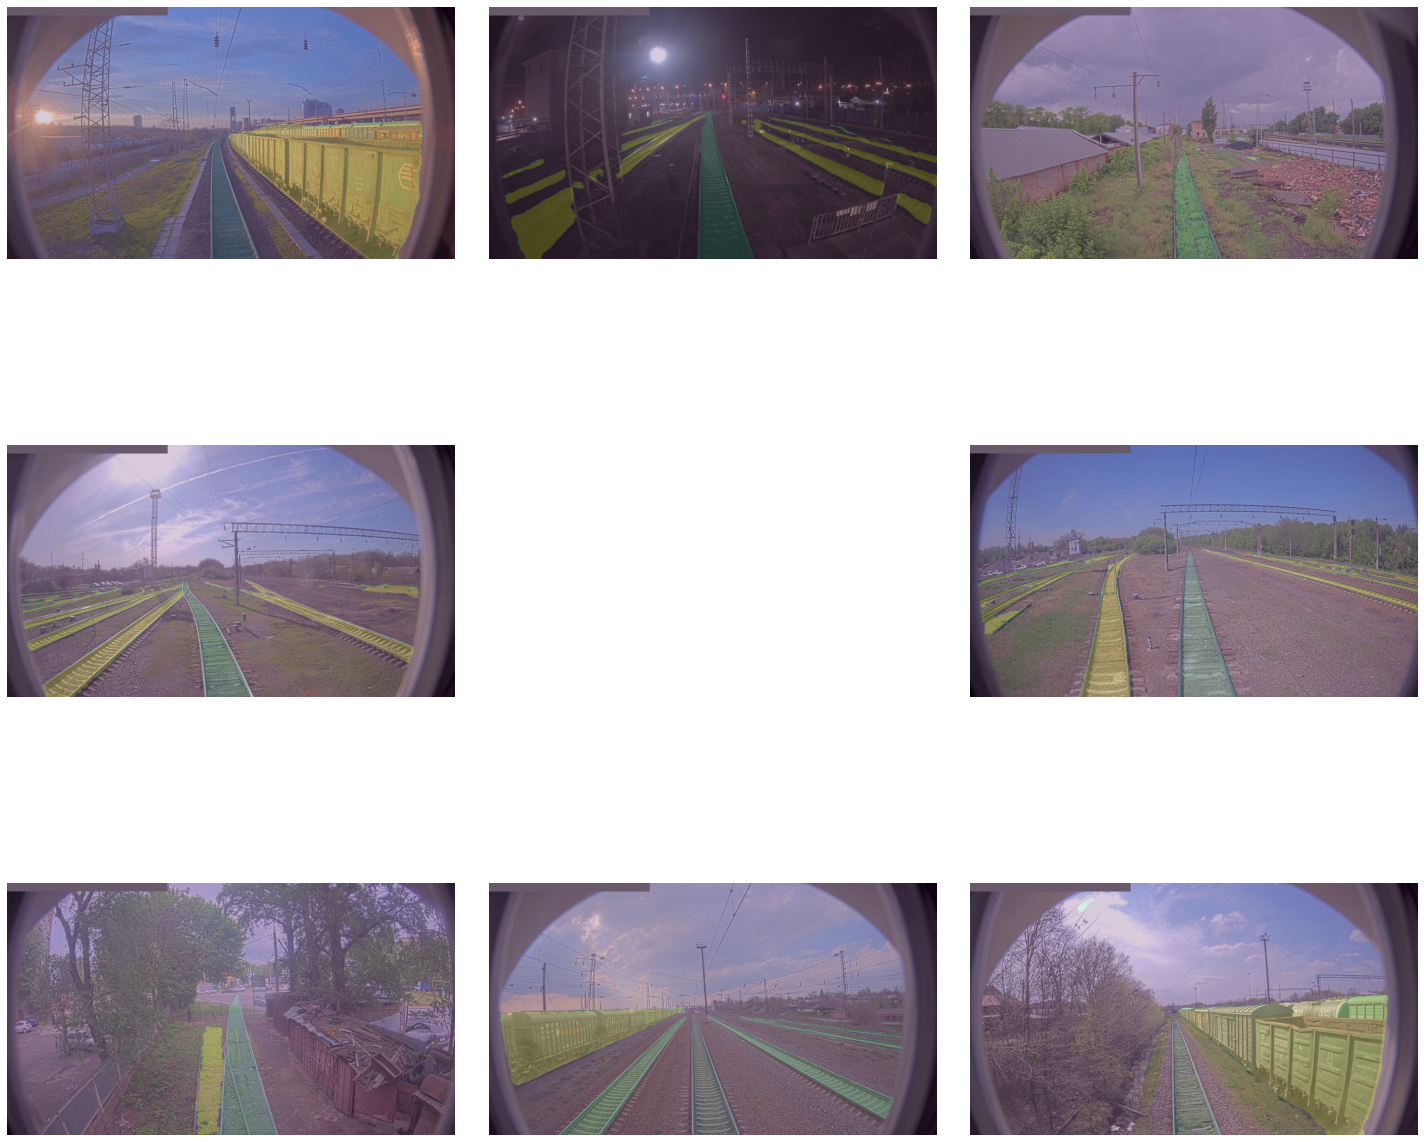

In [48]:
show_batch_t()

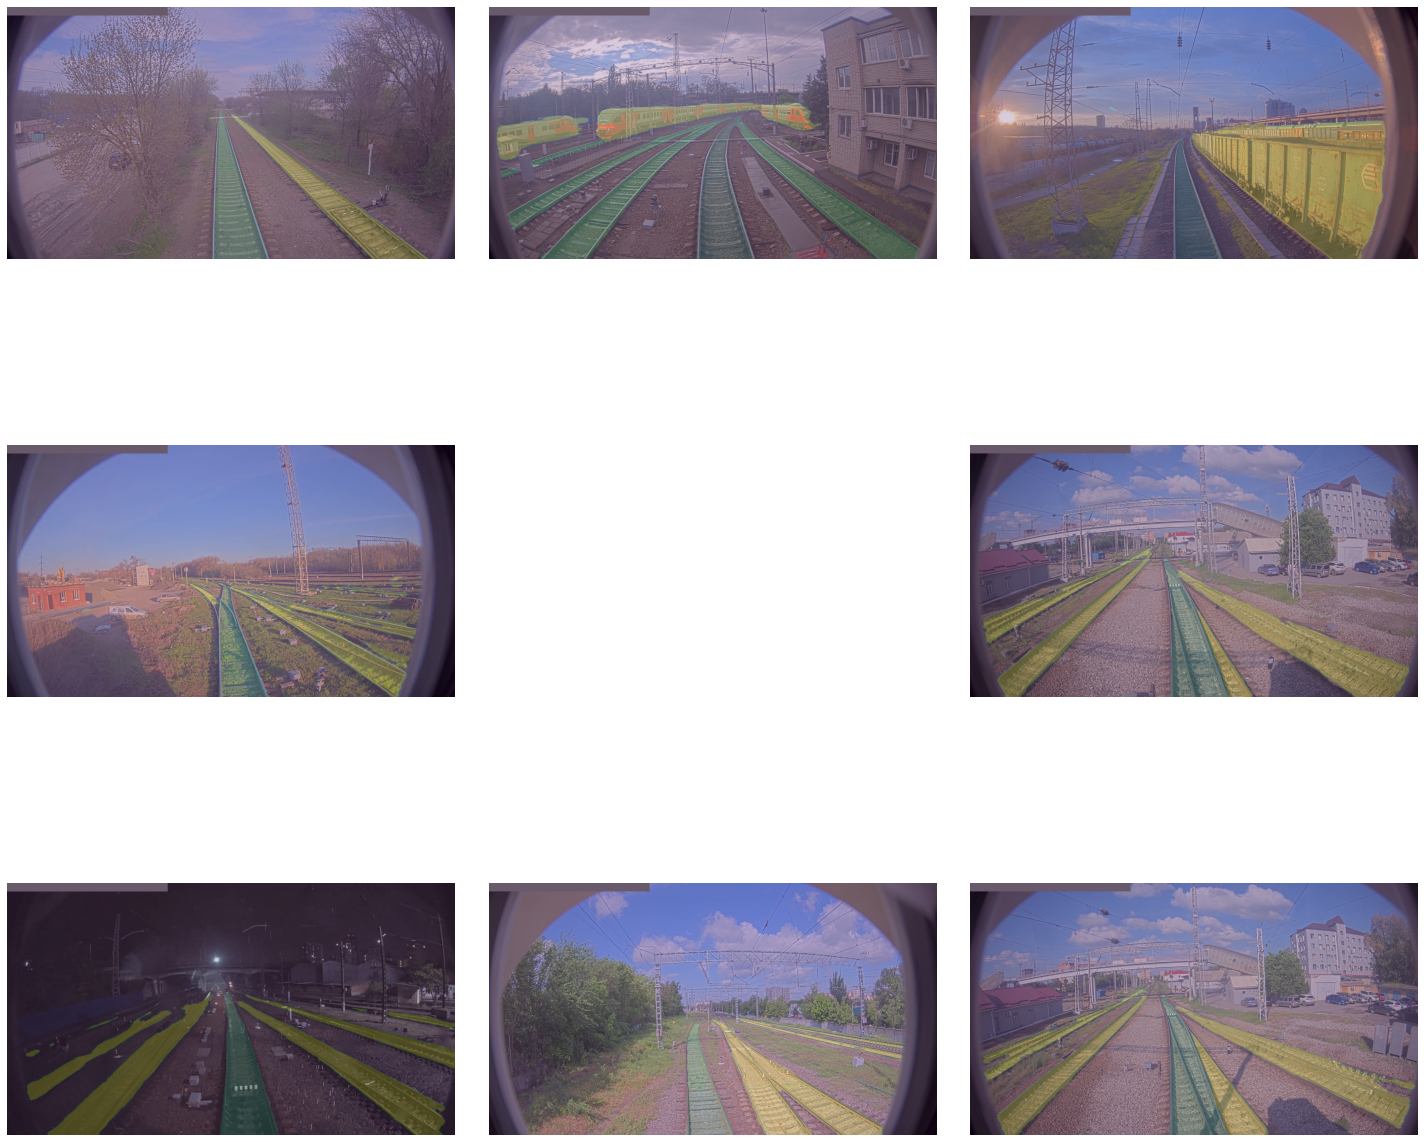

In [49]:
show_batch_t()

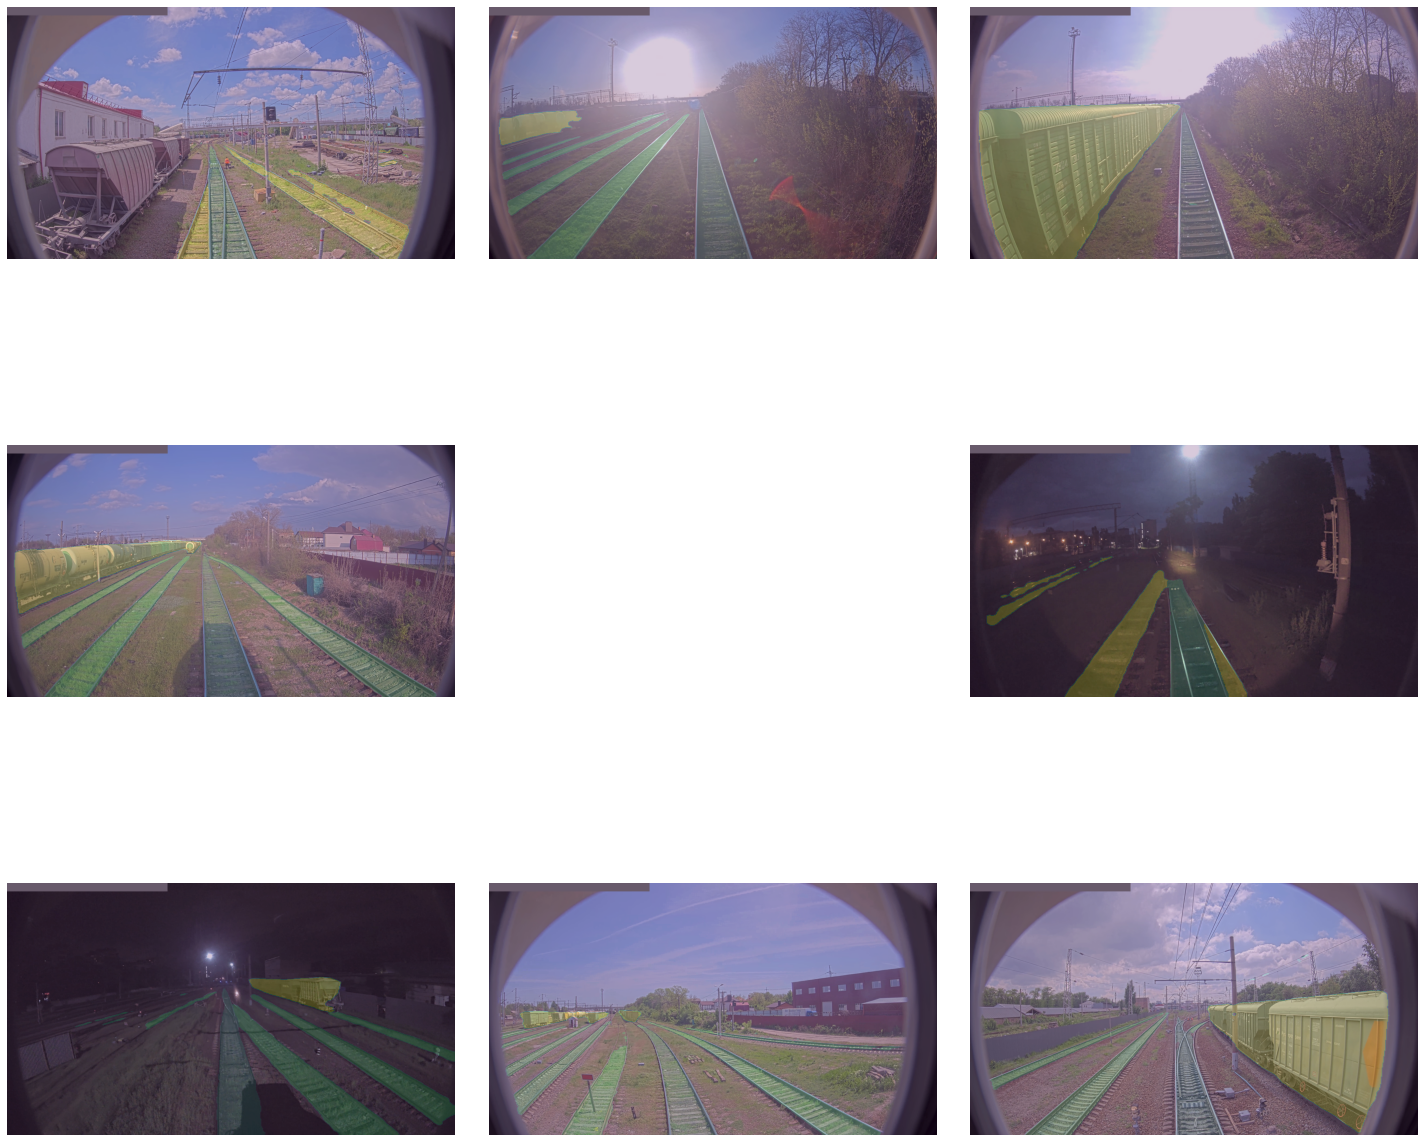

In [47]:
show_batch_t()

In [59]:
show_examples('final', dataset_check[900])

NameError: name 'show_examples' is not defined